# Project: Find best inventory to purchase for a local grocery store

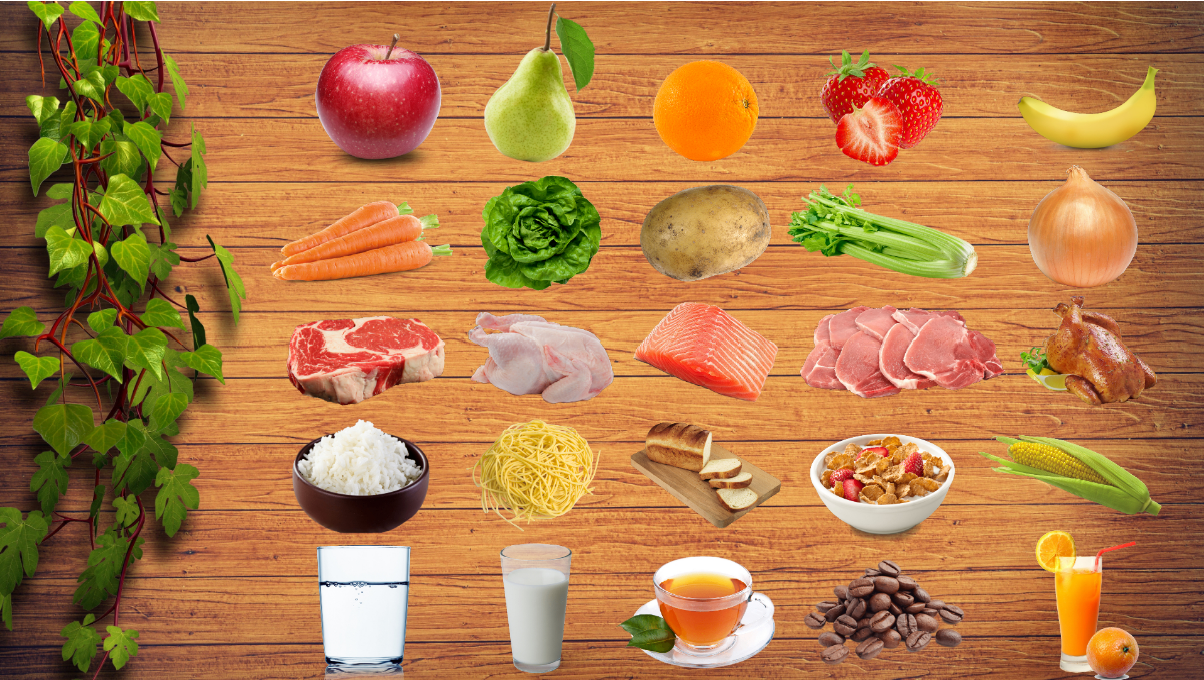

### What can be in the inventory?

Due to the limited capabilities of quantum computers, this problem will be limited to using only the below items in a grocery store. The assumed prices of each item are also listed (per pound).

* Fruits: ($\$1.31$) apples, ($\$1.52$) pears, ($\$1.45$) oranges, ($\$2.51$) strawberries, ($\$0.62$) bananas
* Vegetables: ($\$1.06$) carrots, ($\$3.47$) lettuce, ($\$0.78$) potatoes, ($\$0.46$) celery, ($\$0.41$) onions
* Meats: ($\$4.77$) beef, ($\$1.63$) chicken, ($\$9.99$) fish, ($\$6.50$) pork, ($\$1.36$) turkey
* Grains: ($\$0.82$) rice, ($\$1.09$) pasta, ($\$1.53$) bread, ($\$2.89$) cereal, ($\$3.26$) corn
* Liquids: ($\$0.001$) water, ($\$0.50$) milk, ($\$0.31$) tea, ($\$1.88$) coffee, ($\$1.00$) juice

### The Optimization Problem
The optimization problem is to maximize the number of items in the store, while also remaining within budget. This can be created into a mathematical problem as follows:

$\begin{split}\begin{aligned}
\max_{x \in \{0, b\}^n} px \\
\text{subject to: } p^T x = B
\end{aligned}\end{split}$
where I use the following notation:
* $x \in \{0, b\}^n$ denotes the items to purchase as a vector with a maximum of $b$ for each item,
* $p \in \{0, \infty\}^n$ denotes the prices of the items as a vector,
* $B$ denotes the budget, i.e. the amount of money to be used to select a number of items out of $n$.

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit.circuit.library import EfficientSU2, QAOAAnsatz
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.providers.aer.noise import NoiseModel

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

In [2]:
algorithm_globals.random_seed = 1234
algorithm_globals.massive = True

In [3]:
# costs are per pound
fruits = ['apples', 'pears', 'oranges', 'strawberries', 'bananas']
fruit_prices = np.array([1.31, 1.52, 1.45, 2.51, 0.62])
vegetables = ['carrots', 'lettuces', 'potatoes', 'celery', 'onions']
vegetable_prices = np.array([1.06, 3.47, 0.78, 0.46, 0.41])
meats = ['beef', 'chicken', 'fish', 'pork', 'turkey']
meat_prices = np.array([4.77, 1.63, 9.99, 6.50, 1.36])
grains = ['rice', 'pasta', 'bread', 'cereal', 'corn']
grain_prices = np.array([0.82, 1.09, 1.53, 2.89, 3.26])
liquids = ['water', 'milk', 'tea', 'coffee', 'juice']
liquid_prices = np.array([0.001, 0.50, 0.31, 1.88, 1.00])
fruit_budget = 30
item_limit = 2**3 # Must be 2^x

In [4]:
fruit_prices_adj = np.ceil(fruit_prices)
vegetable_prices_adj = np.ceil(vegetable_prices)
meat_prices_adj = np.ceil(meat_prices)
grain_prices_adj = np.ceil(grain_prices)
liquid_prices_adj = np.ceil(liquid_prices)

In [5]:
def define_inventory_problem(item_names, item_prices, budget, item_upper_limit, price_adj_scalar=1):
    problem_item_prices = np.array([np.ceil(e * price_adj_scalar) for e in item_prices])
    problem_budget = np.ceil(budget * price_adj_scalar)
    qp = QuadraticProgram(name='Inventory')
    qp.integer_var_dict(keys=item_names, lowerbound=1, upperbound=item_upper_limit)
    qp.maximize(
        linear = [1 for i in range(len(item_names))]
    )
    qp.linear_constraint(linear=problem_item_prices, sense='=', rhs=problem_budget)
    return qp

In [6]:
fruit_qp = define_inventory_problem(fruits, fruit_prices, fruit_budget, item_limit, price_adj_scalar=100)
fruit_qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Inventory

Maximize
 obj: xapples + xpears + xoranges + xstrawberries + xbananas
Subject To
 c0: 131 xapples + 152 xpears + 145 xoranges + 251 xstrawberries + 62 xbananas
      = 3000

Bounds
 1 <= xapples <= 8
 1 <= xpears <= 8
 1 <= xoranges <= 8
 1 <= xstrawberries <= 8
 1 <= xbananas <= 8

Generals
 xapples xpears xoranges xstrawberries xbananas
End

In [7]:
fruit_qubo = QuadraticProgramToQubo().convert(fruit_qp)
fruit_qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Inventory

Minimize
 obj: - 21306889 xapples@0 - 42613778 xapples@1 - 85227556 xapples@2
      - 24722497 xpears@0 - 49444994 xpears@1 - 98889988 xpears@2
      - 23583961 xoranges@0 - 47167922 xoranges@1 - 94335844 xoranges@2
      - 40824649 xstrawberries@0 - 81649298 xstrawberries@1
      - 163298596 xstrawberries@2 - 10084177 xbananas@0 - 20168354 xbananas@1
      - 40336708 xbananas@2 + [ 1235592 xapples@0^2
      + 4942368 xapples@0*xapples@1 + 9884736 xapples@0*xapples@2
      + 2867328 xapples@0*xpears@0 + 5734656 xapples@0*xpears@1
      + 11469312 xapples@0*xpears@2 + 2735280 xapples@0*xoranges@0
      + 5470560 xapples@0*xoranges@1 + 10941120 xapples@0*xoranges@2
      + 4734864 xapples@0*xstrawberries@0 + 9469728 xapples@0*xstrawberries@1
      + 18939456 xapples@0*xstrawberries@2 + 1169568 xapples@0*xbananas@0
      + 2339136 xapples@0*xbananas@1 + 4678272 xapples@0*xbananas@2
      + 4942368 xa

In [8]:
# Why is this important?
# Quantum computers have limits to the number of qubits that can be run. Furthermore, the computational complexity
# and time exponentionally increases with each addittional qubit.

def get_qubit_number(qubo):
    ising_operations, _ = (
        qubo
        .to_ising()
    )
    num_qubits = ising_operations.num_qubits
    print(f'Number of qubits required is {ising_operations.num_qubits}.')
    return num_qubits
    
fruit_num_qubits = get_qubit_number(fruit_qubo)

Number of qubits required is 15.


#### Helper Functions
The first function is to convert the result from solving a QUBO, or Quadratic Unconstrained Binary Optimization, into a more readable format. The following two result printer functions display the final results as number of shares and the amount of budget used to purchase the specified shares.

In [9]:
def convert_qubo_result(result, names, item_limit):
    converted_result = {}
    result_x = np.round(result.x)
    item_limit_binary = int(len(result_x) / len(names))
    for i, e in enumerate(names):
        result_i = list(reversed(result_x[i*item_limit_binary:(i+1)*item_limit_binary]))
        result_i = [str(int(e_ij)) for e_ij in result_i]
        result_i = ''.join(result_i)
        converted_result[e] = int(result_i, 2) + 1
    return converted_result

def print_converted_result(converted_result, budget, costs):
    print(f'Solution found with a ${budget:,.2f} budget:\n')
    result_x = np.array(list(converted_result.values()))
    total_cost = np.dot(result_x, costs.T)
    print(f'Total cost of items to buy is ${total_cost:,.2f}.')
    print(f'Items to buy are: ')
    _items = list(converted_result.keys())
    for itemIndex, itemAmount in enumerate(result_x):
        print(f'\t{itemAmount} pounds of {_items[itemIndex]} at ${costs[itemIndex]:,.2f} each')

#### Classical Solution

In [10]:
fruit_exact_mes = NumPyMinimumEigensolver()
fruit_exact_eigensolver = MinimumEigenOptimizer(fruit_exact_mes)

fruit_result = fruit_exact_eigensolver.solve(fruit_qubo)
fruit_result

optimal function value: -24.0
optimal value: [1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1.]
status: SUCCESS

In [11]:
fruit_converted_result = convert_qubo_result(fruit_result, fruits, item_limit)
print_converted_result(fruit_converted_result, fruit_budget, fruit_prices)

Solution found with a $30.00 budget:

Total cost of items to buy is $30.00.
Items to buy are: 
	4 pounds of apples at $1.31 each
	4 pounds of pears at $1.52 each
	6 pounds of oranges at $1.45 each
	2 pounds of strawberries at $2.51 each
	8 pounds of bananas at $0.62 each


According to this classical solution, the local store owner should purchase 3 pounds of apples, 5 pounds of pears, 5 pounds of oranges, and 1 pound of strawberries to remain in budget.

### VQE Solution

In [12]:
seed = 123
backend = Aer.get_backend('qasm_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=200)
ry = TwoLocal(num_qubits=fruit_num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
fruit_vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=qi)
fruit_vqe = MinimumEigenOptimizer(fruit_vqe_mes)
fruit_vqe_result = fruit_vqe.solve(fruit_qubo)
fruit_vqe_result

optimal function value: -20.0
optimal value: [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
status: SUCCESS

In [13]:
converted_fruit_vqe_result = convert_qubo_result(fruit_vqe_result, fruits, item_limit)
print_converted_result(converted_fruit_vqe_result, fruit_budget, fruit_prices)

Solution found with a $30.00 budget:

Total cost of items to buy is $30.00.
Items to buy are: 
	8 pounds of apples at $1.31 each
	2 pounds of pears at $1.52 each
	1 pounds of oranges at $1.45 each
	5 pounds of strawberries at $2.51 each
	4 pounds of bananas at $0.62 each


The Variational Quantum Eigensolver returns the same solution as the classical solution with 8 pounds of apples, 2 pounds of pears, 1 pound of oranges, 5 pounds of strawberries, and 4 pounds of bananas. However, in some cases, due to noise of quantum computing, the result of the classical and quantum solution may differ slightly.

Next is to optimize the store for the other types of groceries.

#### Vegetables

In [14]:
vegetable_budget = 40
vegetable_qp = define_inventory_problem(vegetables, vegetable_prices, vegetable_budget, item_limit, price_adj_scalar=100)
print(vegetable_qp)
vegetable_qubo = QuadraticProgramToQubo().convert(vegetable_qp)
vegetable_num_qubits = get_qubit_number(vegetable_qubo)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Inventory

Maximize
 obj: xcarrots + xlettuces + xpotatoes + xcelery + xonions
Subject To
 c0: 106 xcarrots + 347 xlettuces + 78 xpotatoes + 46 xcelery + 41 xonions = 
     4000

Bounds
 1 <= xcarrots <= 8
 1 <= xlettuces <= 8
 1 <= xpotatoes <= 8
 1 <= xcelery <= 8
 1 <= xonions <= 8

Generals
 xcarrots xlettuces xpotatoes xcelery xonions
End

Number of qubits required is 15.


In [15]:
# Classical Solution
print('Classical Solution:\n')
vegetable_exact_mes = NumPyMinimumEigensolver()
vegetable_exact_eigensolver = MinimumEigenOptimizer(vegetable_exact_mes)
vegetable_result = vegetable_exact_eigensolver.solve(vegetable_qubo)
converted_vegetable_result = convert_qubo_result(vegetable_result, vegetables, item_limit)
print_converted_result(converted_vegetable_result, vegetable_budget, vegetable_prices)

# VQE Solution
cobyla = COBYLA()
cobyla.set_options(maxiter=200)
vegetable_ry = TwoLocal(num_qubits=vegetable_num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
vegetable_vqe_mes = VQE(vegetable_ry, optimizer=cobyla, quantum_instance=qi)
vegetable_vqe = MinimumEigenOptimizer(vegetable_vqe_mes)

print('\n\n\nVQE Solution:\n')
vegetable_vqe_result = vegetable_vqe.solve(vegetable_qubo)
converted_vegetable_vqe_result = convert_qubo_result(vegetable_vqe_result, vegetables, item_limit)
print_converted_result(converted_vegetable_vqe_result, vegetable_budget, vegetable_prices)

Classical Solution:

Solution found with a $40.00 budget:

Total cost of items to buy is $40.00.
Items to buy are: 
	5 pounds of carrots at $1.06 each
	7 pounds of lettuces at $3.47 each
	6 pounds of potatoes at $0.78 each
	8 pounds of celery at $0.46 each
	5 pounds of onions at $0.41 each



VQE Solution:

Solution found with a $40.00 budget:

Total cost of items to buy is $39.98.
Items to buy are: 
	5 pounds of carrots at $1.06 each
	8 pounds of lettuces at $3.47 each
	5 pounds of potatoes at $0.78 each
	3 pounds of celery at $0.46 each
	4 pounds of onions at $0.41 each


#### Meats

In [16]:
meat_budget = 90
meat_qp = define_inventory_problem(meats, meat_prices, meat_budget, item_limit, price_adj_scalar=100)
print(meat_qp)
meat_qubo = QuadraticProgramToQubo().convert(meat_qp)
meat_num_qubits = get_qubit_number(meat_qubo)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Inventory

Maximize
 obj: xbeef + xchicken + xfish + xpork + xturkey
Subject To
 c0: 477 xbeef + 163 xchicken + 999 xfish + 650 xpork + 136 xturkey = 9000

Bounds
 1 <= xbeef <= 8
 1 <= xchicken <= 8
 1 <= xfish <= 8
 1 <= xpork <= 8
 1 <= xturkey <= 8

Generals
 xbeef xchicken xfish xpork xturkey
End

Number of qubits required is 15.


In [17]:
# Classical Solution
print('Classical Solution:\n')
meat_exact_mes = NumPyMinimumEigensolver()
meat_exact_eigensolver = MinimumEigenOptimizer(meat_exact_mes)
meat_result = meat_exact_eigensolver.solve(meat_qubo)
converted_meat_result = convert_qubo_result(meat_result, meats, item_limit)
print_converted_result(converted_meat_result, meat_budget, meat_prices)

# VQE Solution
cobyla = COBYLA()
cobyla.set_options(maxiter=200)
meat_ry = TwoLocal(num_qubits=meat_num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
meat_vqe_mes = VQE(meat_ry, optimizer=cobyla, quantum_instance=qi)
meat_vqe = MinimumEigenOptimizer(meat_vqe_mes)

print('\n\n\nVQE Solution:\n')
meat_vqe_result = meat_vqe.solve(meat_qubo)
converted_meat_vqe_result = convert_qubo_result(meat_vqe_result, meats, item_limit)
print_converted_result(converted_meat_vqe_result, meat_budget, meat_prices)

Classical Solution:

Solution found with a $90.00 budget:

Total cost of items to buy is $90.00.
Items to buy are: 
	4 pounds of beef at $4.77 each
	5 pounds of chicken at $1.63 each
	3 pounds of fish at $9.99 each
	4 pounds of pork at $6.50 each
	5 pounds of turkey at $1.36 each



VQE Solution:

Solution found with a $90.00 budget:

Total cost of items to buy is $90.21.
Items to buy are: 
	1 pounds of beef at $4.77 each
	1 pounds of chicken at $1.63 each
	5 pounds of fish at $9.99 each
	5 pounds of pork at $6.50 each
	1 pounds of turkey at $1.36 each


#### Grains

In [18]:
grain_budget = 20
grain_qp = define_inventory_problem(grains, grain_prices, grain_budget, item_limit, price_adj_scalar=100)
print(grain_qp)
grain_qubo = QuadraticProgramToQubo().convert(grain_qp)
grain_num_qubits = get_qubit_number(grain_qubo)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Inventory

Maximize
 obj: xrice + xpasta + xbread + xcereal + xcorn
Subject To
 c0: 82 xrice + 110 xpasta + 153 xbread + 289 xcereal + 326 xcorn = 2000

Bounds
 1 <= xrice <= 8
 1 <= xpasta <= 8
 1 <= xbread <= 8
 1 <= xcereal <= 8
 1 <= xcorn <= 8

Generals
 xrice xpasta xbread xcereal xcorn
End

Number of qubits required is 15.


In [19]:
# Classical Solution
print('Classical Solution:\n')
grain_exact_mes = NumPyMinimumEigensolver()
grain_exact_eigensolver = MinimumEigenOptimizer(grain_exact_mes)
grain_result = grain_exact_eigensolver.solve(grain_qubo)
converted_grain_result = convert_qubo_result(grain_result, grains, item_limit)
print_converted_result(converted_grain_result, grain_budget, grain_prices)

# VQE Solution
cobyla = COBYLA()
cobyla.set_options(maxiter=200)
grain_ry = TwoLocal(num_qubits=grain_num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
grain_vqe_mes = VQE(grain_ry, optimizer=cobyla, quantum_instance=qi)
grain_vqe = MinimumEigenOptimizer(grain_vqe_mes)

print('\n\n\nVQE Solution:\n')
grain_vqe_result = grain_vqe.solve(grain_qubo)
converted_grain_vqe_result = convert_qubo_result(grain_vqe_result, grains, item_limit)
print_converted_result(converted_grain_vqe_result, grain_budget, grain_prices)

Classical Solution:

Solution found with a $20.00 budget:

Total cost of items to buy is $19.94.
Items to buy are: 
	3 pounds of rice at $0.82 each
	6 pounds of pasta at $1.09 each
	1 pounds of bread at $1.53 each
	1 pounds of cereal at $2.89 each
	2 pounds of corn at $3.26 each



VQE Solution:

Solution found with a $20.00 budget:

Total cost of items to buy is $20.01.
Items to buy are: 
	4 pounds of rice at $0.82 each
	3 pounds of pasta at $1.09 each
	1 pounds of bread at $1.53 each
	3 pounds of cereal at $2.89 each
	1 pounds of corn at $3.26 each


#### Liquids

In [20]:
liquid_budget = 15
liquid_qp = define_inventory_problem(liquids, liquid_prices, liquid_budget, item_limit, price_adj_scalar=100)
print(liquid_qp)
liquid_qubo = QuadraticProgramToQubo().convert(liquid_qp)
liquid_num_qubits = get_qubit_number(liquid_qubo)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Inventory

Maximize
 obj: xwater + xmilk + xtea + xcoffee + xjuice
Subject To
 c0: xwater + 50 xmilk + 31 xtea + 188 xcoffee + 100 xjuice = 1500

Bounds
 1 <= xwater <= 8
 1 <= xmilk <= 8
 1 <= xtea <= 8
 1 <= xcoffee <= 8
 1 <= xjuice <= 8

Generals
 xwater xmilk xtea xcoffee xjuice
End

Number of qubits required is 15.


In [21]:
# Classical Solution
print('Classical Solution:\n')
liquid_exact_mes = NumPyMinimumEigensolver()
liquid_exact_eigensolver = MinimumEigenOptimizer(liquid_exact_mes)
liquid_result = liquid_exact_eigensolver.solve(liquid_qubo)
converted_liquid_result = convert_qubo_result(liquid_result, liquids, item_limit)
print_converted_result(converted_liquid_result, liquid_budget, liquid_prices)

# VQE Solution
cobyla = COBYLA()
cobyla.set_options(maxiter=200)
liquid_ry = TwoLocal(num_qubits=liquid_num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=1, entanglement='full')
liquid_vqe_mes = VQE(liquid_ry, optimizer=cobyla, quantum_instance=qi)
liquid_vqe = MinimumEigenOptimizer(liquid_vqe_mes)

print('\n\n\nVQE Solution:\n')
liquid_vqe_result = liquid_vqe.solve(liquid_qubo)
converted_liquid_vqe_result = convert_qubo_result(liquid_vqe_result, liquids, item_limit)
print_converted_result(converted_liquid_vqe_result, liquid_budget, liquid_prices)

Classical Solution:

Solution found with a $15.00 budget:

Total cost of items to buy is $14.94.
Items to buy are: 
	7 pounds of water at $0.00 each
	8 pounds of milk at $0.50 each
	7 pounds of tea at $0.31 each
	2 pounds of coffee at $1.88 each
	5 pounds of juice at $1.00 each



VQE Solution:

Solution found with a $15.00 budget:

Total cost of items to buy is $14.95.
Items to buy are: 
	5 pounds of water at $0.00 each
	1 pounds of milk at $0.50 each
	7 pounds of tea at $0.31 each
	6 pounds of coffee at $1.88 each
	1 pounds of juice at $1.00 each
